# Exploration

This section implements pure exploration process where the next infill point is obtained by maximizing the uncertainty in model prediction. Below code imports required packages, defines modified branin function, and creates plotting data:

In [2]:
# Imports
import numpy as np
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    a = 1.
    b = 5.1 / (4.*np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8.*np.pi)

    y = a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

# Bounds
lb = np.array([-5, 0])
ub = np.array([10, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ))
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)

Differential evolution (DE) from `pymoo` is used for minimizing the surrogate model. Below code defines problem class and initializes DE. Note that the problem class uses the surrogate model prediction uncertainty instead of the actual function.

In [3]:
# Problem class
class Exploration(Problem):

    def __init__(self, sm):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = - np.sqrt(self.sm.predict_variances(x)) # Standard deviation

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

Below block of code creates 10 training points and performs sequential sampling using exploration. The maximum number of iterations is set to 30 and a convergence criterion is defined based on the value of maximum uncertainty.

In [4]:
sampler = LHS(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ) , criterion='ese')

# Training data
num_train = 10
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)

# Variables
itr = 0
max_itr = 30
tol = 0.1
max_unc = [1]
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_unc[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the minimum of surrogate model
    result = minimize(Exploration(sm), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))
    
    if itr == 0:
        max_unc = [-result.F]
    else:
        max_unc.append(-result.F)
    
    print("Max uncertainty: {}".format(max_unc[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number


Iteration 1
Max uncertainty: [31.45507005]

Iteration 2
Max uncertainty: [20.69180658]

Iteration 3
Max uncertainty: [21.54510105]

Iteration 4
Max uncertainty: [28.00056849]

Iteration 5
Max uncertainty: [28.90382426]

Iteration 6
Max uncertainty: [21.33452458]

Iteration 7
Max uncertainty: [25.76007746]

Iteration 8
Max uncertainty: [12.11431752]

Iteration 9
Max uncertainty: [10.72202523]

Iteration 10
Max uncertainty: [13.37876836]

Iteration 11
Max uncertainty: [15.86912662]

Iteration 12
Max uncertainty: [11.06549901]

Iteration 13
Max uncertainty: [3.38899589]

Iteration 14
Max uncertainty: [2.8320413]

Iteration 15
Max uncertainty: [2.27780155]

Iteration 16
Max uncertainty: [1.67920869]

Iteration 17
Max uncertainty: [1.52343277]

Iteration 18
Max uncertainty: [0.95709217]

Iteration 19
Max uncertainty: [0.76521426]

Iteration 20
Max uncertainty: [0.84509039]

Iteration 21
Max uncertainty: [0.25717433]

Iteration 22
Max uncertainty: [0.23100111]

Iteration 23
Max uncertainty:

Below code plots the convergence of the exploration process.

Text(0.5, 1.0, 'Exploration')

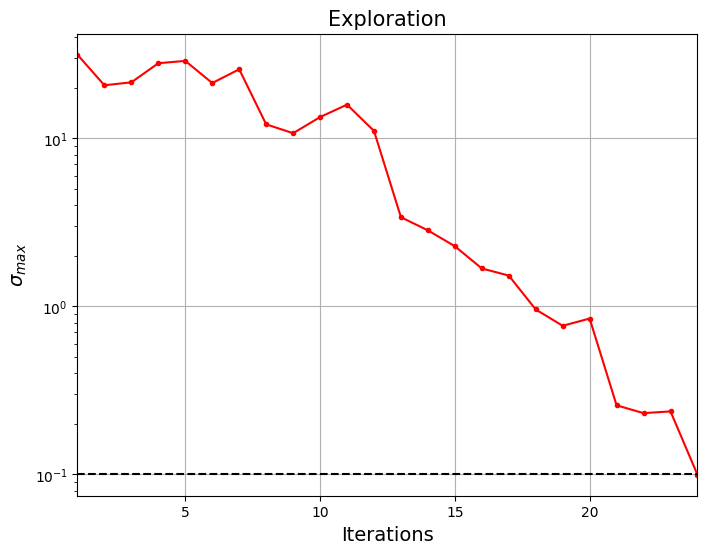

In [5]:
####################################### Plotting convergence history

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(itr) + 1, max_unc, c="red", marker=".")
ax.plot(np.arange(itr) + 1, [tol]*(itr), c="black", linestyle="--", label="Tolerance")
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel(r"$\sigma _{max}$", fontsize=14)
ax.set_xlim(left=1, right=itr)
ax.grid()
ax.set_yscale("log")
ax.set_title("Exploration".format(itr), fontsize=15)

Note that process terminated before reaching maximum number of iterations since the $\sigma_{max}$ is below given tolerance. This essentially means that model is more or less globally accurate and will be confident about its prediction. Next block minimizes the surrogate model prediction using differential evolution.

In [6]:
# Problem class
class SurrogatePrediction(Problem):

    def __init__(self, sm):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = self.sm.predict_values(x)

result = minimize(SurrogatePrediction(sm), algorithm, verbose=False)

print("Minimum of surrogate:\n")
print("x* = {}".format(result.X))
print("f(x*) = {}".format(result.F))

Minimum of surrogate:

x* = [-3.70034944 13.66646216]
f(x*) = [-16.57914514]


The obtained optimum is quite close to the true global minimum which shows that a globally accurate model is created using exploration process. But  the number of infill points needed for accurate model is high which makes the process computationally expensive. The optimum can be obtained using less number of infill points by using a more efficient infill criterion.

Below block of code plots the infill points and minimum of the objective surrogate.

Text(0.5, 1.0, 'Modified Branin function')

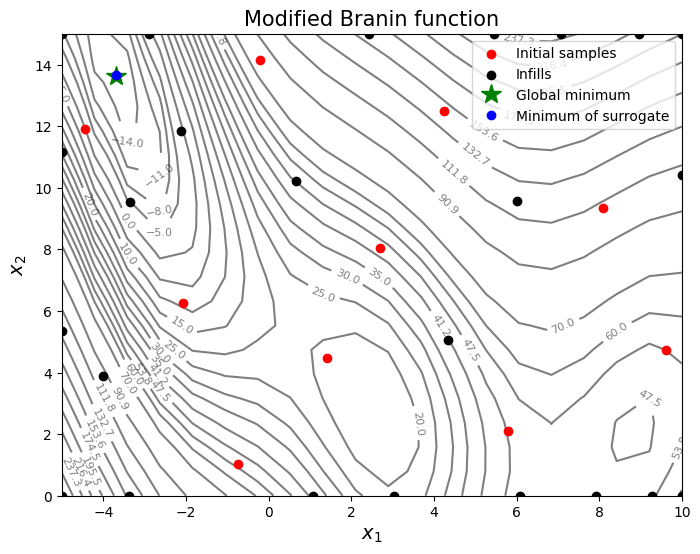

In [8]:
####################################### Plotting initial samples and infills

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)
ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
ax.plot(-3.689, 13.630, 'g*', markersize=15, label="Global minimum")
ax.plot(result.X[0], result.X[1], 'bo', label="Minimum of surrogate")
ax.legend()
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Modified Branin function", fontsize=15)

The infills are added all over the region and not close to minimum value which results in a globally accurate model. As mentioned earlier, exploration process is usually used to build a globally accurate model but is useful to escape a local minimum when combined with exploitation which will enable efficient optimization.

> __*NOTE*__: Due to randomness in differential evolution, results may vary slightly between runs. So, it is recommend to run the code multiple times to see average behavior.

Final result:

| Parameter         | True minimum | Minimum of surrogate|
|-------------------|--------------|---------------------|
| $x_1^*$           | -3.689       | -3.700              |
| $x_2^*$           | 13.630       | 13.667              |
| $f(x_1^*, x_2^*)$ | -16.644      | -16.579             |